In [91]:
import pandas as pd
import numpy as np

## 데이터 전처리 (data_preprocessing.ipynb)
* Date Split
* Weekday
* Lunar Date
* Date Normalization
* 식사명 -> one-hot
* 식사내용 -> bag-of-word

In [92]:
# Read Data
df = pd.read_excel("../data/train.xlsx")

In [93]:
df.head()

,일자,식사명,식사내용,수량
0,20030301,아침,"과일샐러드,닭죽,돈육마늘장조림,떡만두국,부추김무침,쌀밥,딸기잼(중),비엔나구이,스크...",37.472924
1,20030301,저녁,"감자으깸샐러드,비프까스,스위트피클,쌀밥,옥수수스프",19.566787
2,20030301,점심(일반),"골뱅이야채무침,새우맛살튀김,쌀밥(사무직),열무겉절이,칼국수",31.191336
3,20030302,아침,"계란죽,곤약멸치조림,김치국,마카로니샐러드,쌀밥,오징어회무침,딸기잼(중),삶은계란,야...",36.101083
4,20030302,저녁,"계란탕,단무지잔파무침,자장소스,잡채밥,탕수만두",21.949458


In [94]:
def add_weather(df):
    weather = pd.read_excel("../data/[과제3] 관련. 포항지역 날씨 데이터(03~17).xlsx")
    weather['일시'] = [int(x.strftime("%Y%m%d")) for x in weather['일시']]
    
    drop_list = ["지점"]
    for x in weather.columns:
        if weather[x].isnull().sum() > 500:
            drop_list.append(x)
        elif weather[x].isnull().sum() < len(weather):
            weather[x].interpolate(inplace=True)
            if x != '일시':
                weather[x] = weather[x].shift(3)
    weather.drop(drop_list, axis=1, inplace=True)
    
    df = pd.merge(df, weather, how='left', left_on='일자', right_on='일시')
    df.drop(['일시'], axis=1, inplace=True)
    
    return df

In [95]:
# 식사명 변환 (one-hot)
def convert_ont_hot(df):
    df = df.join(pd.get_dummies(df['식사명'], prefix='식사명'))
    df.drop(['식사명'], axis=1, inplace=True)
    return df

In [96]:
def moving_average(df):
    def ma_window(df, window_size):
        morning = df['수량'][df['식사명_아침']==1].rolling(window_size, min_periods=1).mean().shift(3)
        lunch = df['수량'][df['식사명_점심(일반)']==1].rolling(window_size, min_periods=1).mean().shift(3)
        lunch_west = df['수량'][df['식사명_점심(양식)']==1].rolling(window_size, min_periods=1).mean().shift(3)
        dinner = df['수량'][df['식사명_저녁']==1].rolling(window_size, min_periods=1).mean().shift(3)    
        return pd.concat([morning, lunch, lunch_west, dinner]).sort_index()
    df['MA_1day'] = ma_window(df, 1)
    df['MA_3day'] = ma_window(df, 3)
    df['MA_5day'] = ma_window(df, 5)
    df['MA_week'] = ma_window(df, 7)
    df['MA_month'] = ma_window(df, 30)
    df['MA_half_year'] = ma_window(df, 180)
    df['MA_year'] = ma_window(df, 365)
    df.drop(df[df.일자 < 20040326].index, inplace=True)
    df.drop(df[(df.일자 > 20050109) & (df.일자 < 20060331) & (df['식사명_점심(양식)']==1)].index, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [97]:
# 식사내용 변환 (Bag-of-Word)
import konlpy
import re
def menu_dictionary(menu_list):
    def tokenize(text):
        text = text.replace('.', ',')
        text = text.replace('/', ',')
        text = text.replace('&', ',')
        return text.split(',')
    menu = []
    for m in menu_list:
        for mm in tokenize(m):
            mm = re.sub('\(.*?\)', '', mm)
            mm = re.sub('[0-9a-zA-Z]', '', mm)
            menu.append(mm)
    menu = list(set(menu))
    
    okt = konlpy.tag.Okt()
    menu_morphs = []
    for m in menu:
        for ok in okt.morphs(m):
            if len(ok) > 1:
                menu_morphs.append(ok)
    menu_morphs += ['떡', '국', '회', '탕', '밥', '닭', '죽', '찜']
    menu_morphs = list(set(menu_morphs))
    return menu_morphs

def convert_bow(df):
    menu = menu_dictionary(df['식사내용'])
    bow =[]
    for row in df['식사내용']:
        vec = []
        for m in menu:
            if m in row:
                vec.append(1)
            else:
                vec.append(0)
        bow.append(vec)
    bow = np.array(bow)
    df = df.join(pd.DataFrame(bow, columns=menu))
    df.drop(['식사내용'], axis=1, inplace=True)
    return df

In [98]:
# 년/월/일 분리(split) + 요일(Weekday) 추가
def split_date(df):
    # Normalize Date
    df['year'] = (df['일자'] / 10000).astype(int)
    df['month'] = (df['일자'] % 10000 / 100).astype(int)
    df['day'] = (df['일자'] % 100).astype(int)
    df['weekday'] = pd.to_datetime(df['일자'], format = '%Y%m%d').dt.dayofweek
    return df

In [99]:
# 음력 추가
from korean_lunar_calendar import KoreanLunarCalendar
from datetime import datetime

def add_lunar_date(df):
    calendar = KoreanLunarCalendar()
    
    lunar_y = []
    lunar_m = []
    lunar_d = []
    for y, m, d in zip (df['year'], df['month'], df['day']):
        calendar.setSolarDate(y, m, d)
        lunar_date = calendar.LunarIsoFormat()
        lunar_y.append(int(lunar_date[:4]))
        lunar_m.append(int(lunar_date[5:7]))
        lunar_d.append(int(lunar_date[8:10]))
        
    df['lunar_year'], df['lunar_month'], df['lunar_day'] = lunar_y, lunar_m, lunar_d
    return df

In [100]:
# 년/월/일 변환
def year_norm(df):
    df['year'] = (df['year']-min(df['year'])) / (max(df['year'])-min(df['year']))
    df['lunar_year'] = (df['lunar_year']-min(df['lunar_year'])) / (max(df['lunar_year'])-min(df['lunar_year']))
    return df
def month_norm(df):
    df['month_sin'] = [np.sin(x*2*np.pi/12) for x in df['month']]
    df['month_cos'] = [np.cos(x*2*np.pi/12) for x in df['month']]
    df['lunar_month_sin'] = [np.sin(x*2*np.pi/12) for x in df['lunar_month']]
    df['lunar_month_cos'] = [np.cos(x*2*np.pi/12) for x in df['lunar_month']]
    df.drop(['month', 'lunar_month'], axis=1, inplace=True)
    return df
def day_norm(df):
    df['day_sin'] = [np.sin(x*2*np.pi/31) for x in df['day']]
    df['day_cos'] = [np.cos(x*2*np.pi/31) for x in df['day']]
    df['lunar_ay_sin'] = [np.sin(x*2*np.pi/31) for x in df['lunar_day']]
    df['lunar_day_cos'] = [np.cos(x*2*np.pi/31) for x in df['lunar_day']]
    df.drop(['day', 'lunar_day'], axis=1, inplace=True)
    return df
def weekday_norm(df):
    df['weekday_sin'] = [np.sin(x*2*np.pi/7) for x in df['weekday']]
    df['weekday_cos'] = [np.cos(x*2*np.pi/7) for x in df['weekday']]
    return df

In [101]:
# add Weather Information
df = add_weather(df)

# convert 식사명 to one-hot
df = convert_ont_hot(df)

# Moving Average of 수량
df = moving_average(df)

# convert 식사내용 to Bag-of-Word Vector
df = convert_bow(df)

# Date
df = split_date(df)
df = add_lunar_date(df)

# Date Normalization
df = year_norm(df)
df = month_norm(df)
df = day_norm(df)
df = weekday_norm(df)

In [102]:
print("Number of Columns =", len(df.columns))
df.head()

Number of Columns = 870


,일자,수량,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),최대 순간 풍속(m/s),최대 순간 풍속 풍향(16방위),최대 순간풍속 시각(hhmi),...,month_sin,month_cos,lunar_month_sin,lunar_month_cos,day_sin,day_cos,lunar_ay_sin,lunar_day_cos,weekday_sin,weekday_cos
0,20040326,41.877256,10.5,4.6,439.0,17.6,1413.0,10.0,180.0,1620.0,...,1.0,6.123234e-17,0.866025,0.5,-0.848644,0.528964,0.937752,0.347305,-0.433884,-0.900969
1,20040326,13.718412,10.5,4.6,439.0,17.6,1413.0,10.0,180.0,1620.0,...,1.0,6.123234e-17,0.866025,0.5,-0.848644,0.528964,0.937752,0.347305,-0.433884,-0.900969
2,20040326,40.361011,10.5,4.6,439.0,17.6,1413.0,10.0,180.0,1620.0,...,1.0,6.123234e-17,0.866025,0.5,-0.848644,0.528964,0.937752,0.347305,-0.433884,-0.900969
3,20040327,37.184116,11.5,7.2,702.0,15.6,1316.0,8.2,270.0,1333.0,...,1.0,6.123234e-17,0.866025,0.5,-0.724793,0.688967,0.988468,0.151428,-0.974928,-0.222521
4,20040327,12.635379,11.5,7.2,702.0,15.6,1316.0,8.2,270.0,1333.0,...,1.0,6.123234e-17,0.866025,0.5,-0.724793,0.688967,0.988468,0.151428,-0.974928,-0.222521


In [103]:
temp = df

In [104]:
del_list = [
#     '평균기온(°C)',
#     '최저기온(°C)',
    '최저기온 시각(hhmi)',
#     '최고기온(°C)',
    '최고기온 시각(hhmi)',
#     '최대 순간 풍속(m/s)',
    '최대 순간 풍속 풍향(16방위)',
    '최대 순간풍속 시각(hhmi)',
#     '최대 풍속(m/s)',
    '최대 풍속 풍향(16방위)',
    '최대 풍속 시각(hhmi)',
#     '평균 풍속(m/s)',
#     '풍정합(100m)',
#     '평균 이슬점온도(°C)',
#     '최소 상대습도(%)',
    '최소 상대습도 시각(hhmi)',
#     '평균 상대습도(%)',
#     '평균 증기압(hPa)',
#     '평균 현지기압(hPa)',
    '최고 해면기압(hPa)',
    '최고 해면기압 시각(hhmi)',
    '최저 해면기압(hPa)',
    '최저 해면기압 시각(hhmi)',
    '평균 해면기압(hPa)',
    '가조시간(hr)',
#     '합계 일조 시간(hr)',
    '1시간 최다일사 시각(hhmi)',
    '1시간 최다일사량(MJ/m2)',
    '합계 일사(MJ/m2)',
    '평균 전운량(1/10)',
    '평균 중하층운량(1/10)',
#     '평균 지면온도(°C)',
#     '최저 초상온도(°C)',
    '평균 5cm 지중온도(°C)',
    '평균 10cm 지중온도(°C)',
    '평균 20cm 지중온도(°C)',
    '평균 30cm 지중온도(°C)',
    '0.5m 지중온도(°C)',
    '1.0m 지중온도(°C)',
    '1.5m 지중온도(°C)',
    '3.0m 지중온도(°C)',
    '5.0m 지중온도(°C)',
    '합계 소형증발량(mm)',
]

In [105]:
df = temp
df.drop(del_list, axis=1, inplace=True)

In [106]:
df.head()

,일자,수량,평균기온(°C),최저기온(°C),최고기온(°C),최대 순간 풍속(m/s),최대 풍속(m/s),평균 풍속(m/s),풍정합(100m),평균 이슬점온도(°C),...,month_sin,month_cos,lunar_month_sin,lunar_month_cos,day_sin,day_cos,lunar_ay_sin,lunar_day_cos,weekday_sin,weekday_cos
0,20040326,41.877256,10.5,4.6,17.6,10.0,6.3,3.0,2592.0,3.5,...,1.0,6.123234e-17,0.866025,0.5,-0.848644,0.528964,0.937752,0.347305,-0.433884,-0.900969
1,20040326,13.718412,10.5,4.6,17.6,10.0,6.3,3.0,2592.0,3.5,...,1.0,6.123234e-17,0.866025,0.5,-0.848644,0.528964,0.937752,0.347305,-0.433884,-0.900969
2,20040326,40.361011,10.5,4.6,17.6,10.0,6.3,3.0,2592.0,3.5,...,1.0,6.123234e-17,0.866025,0.5,-0.848644,0.528964,0.937752,0.347305,-0.433884,-0.900969
3,20040327,37.184116,11.5,7.2,15.6,8.2,4.6,2.5,2160.0,-0.3,...,1.0,6.123234e-17,0.866025,0.5,-0.724793,0.688967,0.988468,0.151428,-0.974928,-0.222521
4,20040327,12.635379,11.5,7.2,15.6,8.2,4.6,2.5,2160.0,-0.3,...,1.0,6.123234e-17,0.866025,0.5,-0.724793,0.688967,0.988468,0.151428,-0.974928,-0.222521


# Modeling

1. Random Forest
2. XGBoost

## 0. Prepare train & test

#### 1) Split train and test(validation) set by 8 to 2

In [107]:
np.random.seed(10)
shuffled_idx = np.concatenate((df['일자'].unique()[:2000], np.random.permutation(df['일자'].unique()[2000:])))

In [108]:
dev_ratio = 0.2
train_idx = int(len(df['일자'].unique()) * (1-dev_ratio))
shuffled_idx[:train_idx] = np.sort(shuffled_idx[:train_idx])
shuffled_idx[train_idx:] = np.sort(shuffled_idx[train_idx:])

In [109]:
train_df = df[df['일자'].isin(shuffled_idx[:train_idx])]
dev_df = df[df['일자'].isin(shuffled_idx[train_idx:])]

print(train_df.shape)
print(dev_df.shape)

(14687, 842)
(3855, 842)


In [166]:
train_y = train_df['수량']
train_x = train_df.drop(['수량', '일자'], axis=1)
dev_y = dev_df['수량']
dev_x = dev_df.drop(['수량', '일자'], axis=1)
dev_x_iter = dev_df.drop(['수량'], axis=1)

#### 2) train, predict, evaluation function (반복적으로 사용되는 코드이므로)

In [111]:
from sklearn.metrics import mean_squared_error
import math

def train_and_predict(model, train_x, train_y, dev_x):
    model.fit(train_x, train_y)
    return model.predict(dev_x)

def iterative_train_and_predict(model, df, dev_x):
    predictions = []
    dev_dates = dev_x['일자'].unique()
    print("Number of Dates =", len(dev_dates))
    for i, dev_date in enumerate(dev_dates):        
        _train_df = df[df['일자'] < dev_date - 2]
        pred = train_and_predict(model, 
                                 _train_df.drop(['수량', '일자'], axis=1), 
                                 _train_df['수량'], 
                                 dev_x[dev_x['일자']==dev_date].drop(['일자'], axis=1))
        predictions.append(pred)
        
        if((i+1) % (int(len(dev_dates)/10)) == 0):
            print(">>", 10*int((i+1)/(int(len(dev_dates)/10))), "% >>", end="")
    print()
    return np.concatenate(predictions)

def evaluate(predict_y, actual_y):
    predict_y = predict_y
    actual_y = actual_y
    rmse = math.sqrt(mean_squared_error(actual_y, predict_y))
    print('RMSE :', round(np.mean(rmse), 4))

## 1. Random Forest

In [174]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 200, n_jobs=-1, random_state=10)

In [175]:
%%time
pred = train_and_predict(model, train_x, train_y, dev_x)
evaluate(pred, dev_y)

RMSE : 4.2951
CPU times: user 4min 52s, sys: 1.4 s, total: 4min 53s
Wall time: 1min 17s


In [20]:
%%time
pred = iterative_train_and_predict(model, df, dev_x_iter)
evaluate(pred, dev_y)

Number of Dates = 966
>> 10 % >>>> 20 % >>>> 30 % >>>> 40 % >>>> 50 % >>>> 60 % >>>> 70 % >>>> 80 % >>>> 90 % >>>> 100 % >>
RMSE : 4.5401
CPU times: user 1d 21h 53min 8s, sys: 3min, total: 1d 21h 56min 8s
Wall time: 6h 51min 21s


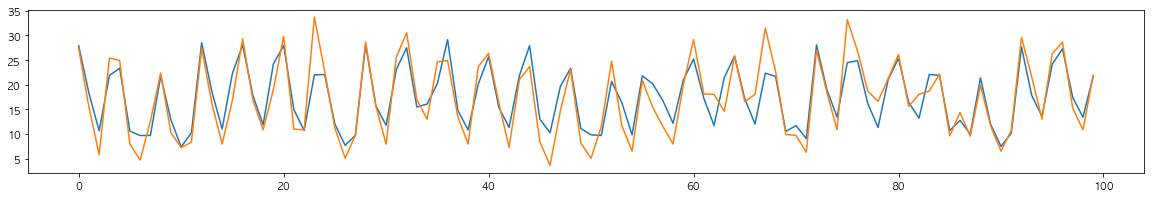

In [177]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

plt.rcParams["figure.figsize"] = (20,3)
index = 500

plt.plot(pred[index:index+100])
plt.plot(dev_y.values[index:index+100])

## 2. XGBoost

In [114]:
import xgboost as xgb
model = xgb.XGBRegressor(n_estimators=200, 
                         learning_rate=0.05, 
                         max_depth=10,
                         colsample_bytree=0.9,
                         gamma=0.4,
                         subsample=0.8,
                         reg_alpha=0.01,
                         seed=10,
                         n_jobs=-1)

In [115]:
%%time
pred = train_and_predict(model, train_x, train_y, dev_x)
evaluate(pred, dev_y)

RMSE : 4.2177
CPU times: user 3min 26s, sys: 1.66 s, total: 3min 28s
Wall time: 3min 18s


In [24]:
%%time
pred = iterative_train_and_predict(model, df, dev_x_iter)
evaluate(pred, dev_y)

Number of Dates = 966
>> 10 % >>>> 20 % >>>> 30 % >>>> 40 % >>>> 50 % >>>> 60 % >>>> 70 % >>>> 80 % >>>> 90 % >>>> 100 % >>
RMSE : 4.4419
CPU times: user 4d 12h 29min 34s, sys: 1h 15min 40s, total: 4d 13h 45min 15s
Wall time: 13h 47min


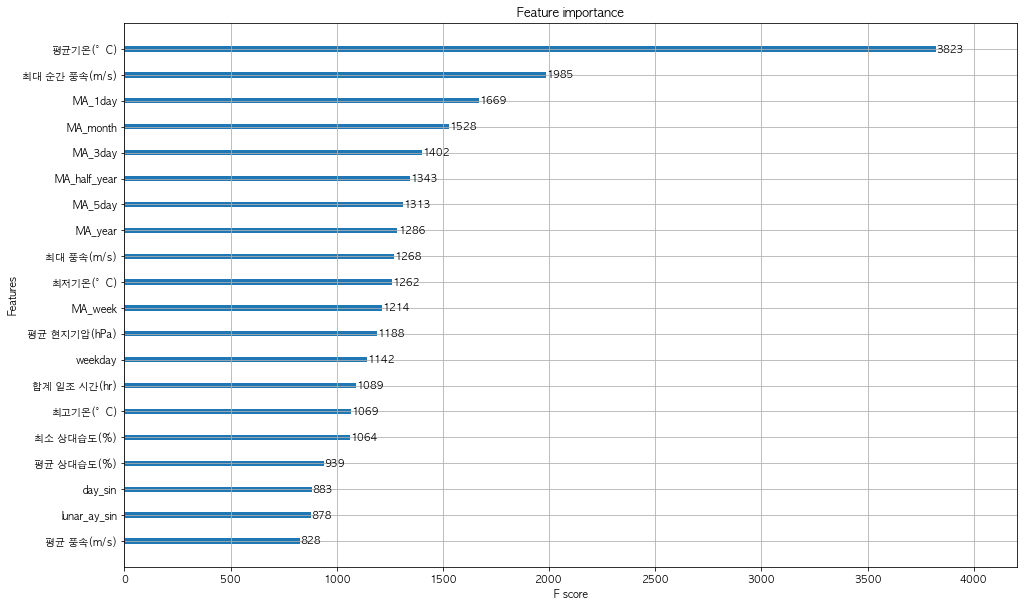

In [117]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

plt.rcParams['figure.figsize'] = (16,10)
plt.rcParams['font.family'] = 'AppleGothic'

xgb.plot_importance(model, max_num_features=20)

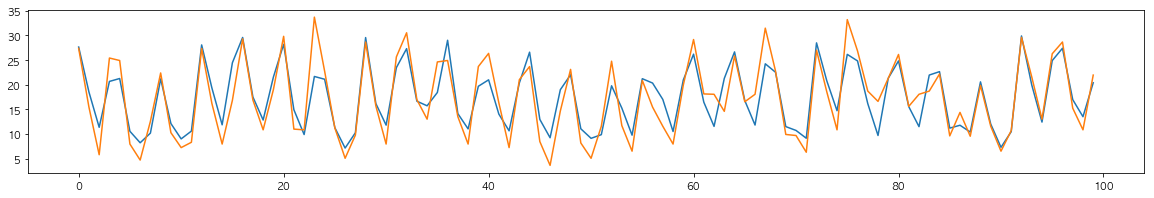

In [118]:
plt.rcParams["figure.figsize"] = (20,3)
index = 500

plt.plot(pred[index:index+100])
plt.plot(dev_y.values[index:index+100])